## Demonstration of notebook served by non-local server.  

### This is the RSM implementaiton in Python with ipwidgets control of the RSM parameters.

In [1]:
from pylab import *
import matplotlib.tri as Tri
import matplotlib.pyplot as plt
%matplotlib notebook

import h5py
import numpy as np
import numpy.matlib as ml
import numpy.linalg as la
import numpy.ma as ma
#import osmapi


import warnings
warnings.filterwarnings('ignore')

#from __future__ import print_function # for python 2
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

#from central_ckv_new import central_ckv

In [2]:
#api = osmapi.OsmApi()
#print api

In [3]:
# import matlab .mat file into python
# get the model in a matlab file, stored as -v7.3
# the model components must be saved as individual variables, 
# not as a struct.  See the matlab code structfields2vars
mf='Model_NC_2Lines_Small.mat';

f = h5py.File(mf, "r")
print f

<HDF5 file "test4.mat" (mode r)>


In [11]:
#print f.keys()
#for name in f:
#     print name
#print "P" in f

global c, k, Nd
global P, R, weights, index

c=np.squeeze(f['c'][:])
k=np.squeeze(f['k'][:])
Nd=np.squeeze(f['n_d'][:])
P=np.transpose(f['P'][:])
R=np.transpose(f['R'][:])
weights=np.squeeze(f['weights'][:])
index=np.squeeze(f['index'][:])
#xtest=np.squeeze(f['X'][:])
xtest=np.array([ 66.8, 1.06, 7.5, 38, 5.23, 5.25])
xtest=np.squeeze(np.transpose(xtest))

Nd=40
c=.4
k=1
weights=np.ones(6)

rmw=xtest[0]
H_b=xtest[1]
TS=xtest[2]
Vmax=xtest[3]
LatNorth=xtest[4]
LatSouth=xtest[5]
#rmw,H_b,TS,Vmax,LatNorth,LatSouth

p1min=np.min(P[:,0]); p1max=np.max(P[:,0])  # rmw
p2min=np.min(P[:,1]); p2max=np.max(P[:,1])  # H_b
p3min=np.min(P[:,2]); p3max=np.max(P[:,2])  # TS
p4min=np.min(P[:,3]); p4max=np.max(P[:,3])  # Vmax
p5min=np.min(P[:,4]); p5max=np.max(P[:,4])  # LatNorth
p6min=np.min(P[:,5]); p6max=np.max(P[:,5])  # LatSouth

dp1=(p1max-p1min)/20
dp2=(p2max-p2min)/20
dp3=(p3max-p3min)/20
dp4=(p4max-p4min)/20
dp5=(p5max-p5min)/20
dp6=(p6max-p6min)/20

# get the FEM grid parts from f to create a triangulation object
lon = np.squeeze(f['x'][:])
lat = np.squeeze(f['y'][:])
latmin = np.mean(lat)  # needed for scaling lon/lat plots
nv  = np.squeeze(f['e'][:,:] -1)
nv=np.transpose(nv)
tri = Tri.Triangulation(lon,lat, triangles=nv)

NodeIndices=np.squeeze(f['NodeIndices'][:])
NodeIndices=(NodeIndices-1).astype(int)

In [12]:
print c, k, Nd
print weights

0.4 1 40
[ 1.  1.  1.  1.  1.  1.]


In [13]:
def sur_model(Normalized_X,
              Weight_Matrix,
              Normalized_P,
              Nd,c,k,
              BasisFxns,
              Normalized_R,
              NSupportPoints,
              index):
    
    one=np.expand_dims(np.ones(1),axis=1)
    
    #Normalized_X=np.dot(v_aux,x)
    #Normalized_X=np.expand_dims(Normalized_X,axis=1)
    
    Parameter_Diffs=ml.repmat(Normalized_X,1,NSupportPoints)-Normalized_P
    Parameter_Diffs_Weighted=np.dot(Weight_Matrix,Parameter_Diffs)
    
    temp=np.square(Parameter_Diffs_Weighted,Parameter_Diffs_Weighted)
    temp=np.sum(temp,axis=0)
    temp=np.expand_dims(temp,axis=0)
    Distance=np.sqrt(temp);

    SortedDistanceIndex=np.argsort(Distance); 
    SortedDistance=Distance[0,SortedDistanceIndex]    
#    D=SortedDistance[0,Nd.astype(int)-1]
    D=SortedDistance[0,Nd-1]

#    SelectedStorms=SortedDistanceIndex[0,:Nd.astype(int)]
    SelectedStorms=SortedDistanceIndex[0,:Nd]


    f=np.exp(-np.power(1/c,k*2))
    denom=(1-f)
    numer=np.exp(-(np.power(Distance/D/c,k*2)))-f
    aux1=numer/denom;

    W=np.diag(aux1[0,SelectedStorms]); 

    Ba=BasisFxns[SelectedStorms,:];
    
    ni=index.shape[0]

    for j in range(0,ni):
        ii=index[j]
        temp=np.array([Normalized_X[ii]*Normalized_X[index[j:ni]]])
        temp=np.squeeze(temp)
        temp=np.expand_dims(temp,axis=1)

        if (j == 0):
            aux=np.array(temp)
        else:
            aux=np.vstack((aux, temp))

    b=np.hstack((one,np.transpose(Normalized_X), np.transpose(aux)))

    # auxiliary matrices
    L=np.dot(np.transpose(Ba),W)
    M=np.dot(L,Ba) 
    
    # force M to be positive definite
    W,v=la.eig(M)
    posdef=all(W>0)
    dM=np.identity(M.shape[0])*(10+M.shape[0])*np.finfo(float32).eps
    while (~posdef):
        M=M+dM
        W,v=la.eig(M)
        posdef=all(W>0)
    
    # auxM are the b'*inv(M)*L coefficients in eqn 24 of Taflanidis 2012
    Mi=la.inv(M)
    temp=np.dot(b,Mi)
    auxM=np.dot(temp,L);

    Fi=Normalized_R[SelectedStorms,:];

    f=np.dot(auxM,Fi)

    return f

In [14]:
def central_ckv (P,
                 R,
                 c,
                 k,
                 weights,
                 Nd,
                 index,
                 xtest):

    one=np.expand_dims(np.ones(1),axis=1)

    P=np.transpose(P)
    ni=index.shape[0]
    index=(index-1).astype(int)    
    
    # normalization of model parameters 
    mean_P=np.mean(P,axis=1)
    mean_P=np.expand_dims(mean_P,axis=1)
    mean_P=np.transpose(mean_P)

    std_P=np.std(P,axis=1,ddof=0);    
    v_aux=np.diag(1/std_P)
    
#    Weight_Matrix=np.diag(weights/std_P); 
    Weight_Matrix=np.diag(weights); 

    std_P=np.expand_dims(std_P,axis=1)
    std_P=np.transpose(std_P)

    # convert model parameters to normalised space
    #Normalized_P=np.dot(v_aux,P)

    temp=P-np.transpose(mean_P)
    Normalized_P=np.dot(v_aux,temp)
    NSupportPoints=Normalized_P.shape[1];  

    Normalized_X=np.dot(v_aux,np.transpose(xtest-mean_P))
    #Normalized_X=expand_dims(np.transpose(xtest),axis=1)
    #print np.min(Normalized_P,axis=1)
    #print np.transpose(Normalized_X)
    #print np.max(Normalized_P,axis=1)
    
    mean_R=np.mean(R,axis=0); 
    mean_R=np.expand_dims(mean_R,axis=1)
    mean_R=np.transpose(mean_R)

    std_R=np.std(R,axis=0,ddof=0);
    std_R=np.expand_dims(std_R,axis=1)

    temp=ml.repmat(mean_R,NSupportPoints,1)
    numer=R-temp
    
    # S will need to be sparse for large grids...
    S=np.array(1/std_R)
    S=np.diag(np.squeeze(S),k=0)
    
    Normalized_R=np.dot(numer,S);

    BasisFxns=np.array([])
    for i in range(0,NSupportPoints): 
        
        for j in range(0,ni):
            ii=index[j]
            temp=np.array([Normalized_P[ii,i]*Normalized_P[index[j:ni],i]])
            temp=np.transpose(temp)

            if (j == 0):
                aux=np.array(temp)
            else:
                aux=np.vstack((aux, temp))
                
        temp=Normalized_P[:,i] 
        temp=np.expand_dims(temp,axis=0)
        aux=np.transpose(aux)
        temp=np.hstack((one,temp, aux))
      
        if (i==0):
            BasisFxns=temp
        else:
            BasisFxns=np.vstack((BasisFxns,temp))
                       
    zhat=sur_model(Normalized_X,Weight_Matrix,Normalized_P,Nd,c,k,BasisFxns,Normalized_R,NSupportPoints,index) 
    
    # send zhat back to un-normalized space
    zhat=zhat*np.transpose(std_R)+mean_R
    
    return zhat

In [15]:
def master(rmw,H_b,TS,Vmax,LatNorth,LatSouth):
    
    global c, k, Nd
    global P, R, weights, index
    
    lon_offset=-82
    
    xtest=np.array([rmw,H_b,TS,Vmax,LatNorth,LatSouth])

    temp=central_ckv(P,R,c,k,weights,Nd,index,xtest)
#    vmin=np.floor(np.nanmin(temp))
    vmin=0
    vmax=np.ceil(np.nanmax(temp))
#    vmax=5
    levels = linspace(vmin,vmax,21)
    
    # put response into variable sized as lon.shape
    zhat=ma.array(np.zeros(tri.x.shape))
    zhat[:]=zhat.fill_value
    zhat[NodeIndices]=temp
    zhat[zhat<0]=0
    
    #print 'Making contours in figure ...'
    fig = plt.figure(figsize=(5,3), dpi=144);
    ax = fig.add_axes([0.0, 0.1, 0.8, 0.8]) 
    ax.set_aspect(1.0/np.cos(latmin * np.pi / 180.0))

    #print 'Calling tricontourf  ...'
    contour = tricontourf(tri, zhat, levels=levels,shading='faceted')
    plt.grid(True)
    plt.xlim((-80,-74))
    plt.ylim((33,37))
    plt.tick_params(axis='both', which='major', labelsize=8)
    plt.title('RSM test in Python', fontsize=12)
    plt.plot([-80, -70],[33.5,33.5],'g-')
    plt.plot([-80, -70],[36.0,36.0],'g-')
    plt.plot([LatSouth+lon_offset],[33.5],'r*-')
    plt.plot([LatNorth+lon_offset],[36.0],'r*-')
    plt.plot([LatNorth+lon_offset, LatSouth+lon_offset],[36.0,33.5],'y-')
    
    # add colorbar
    cbax = fig.add_axes([0.75, 0.1, 0.05, 0.8]) 
    cb = plt.colorbar(contour, cax=cbax,  orientation='vertical')
    cb.set_label('[m MSL]', fontsize=8)
    cb.ax.tick_params(axis='both', which='major', labelsize=8)

<IPython.core.display.Javascript object>


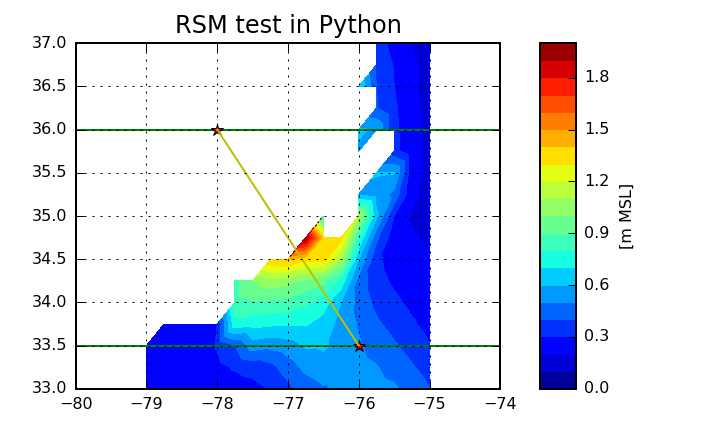

In [16]:
master(66.8,1,7.5,38,4,6)

<IPython.core.display.Javascript object>


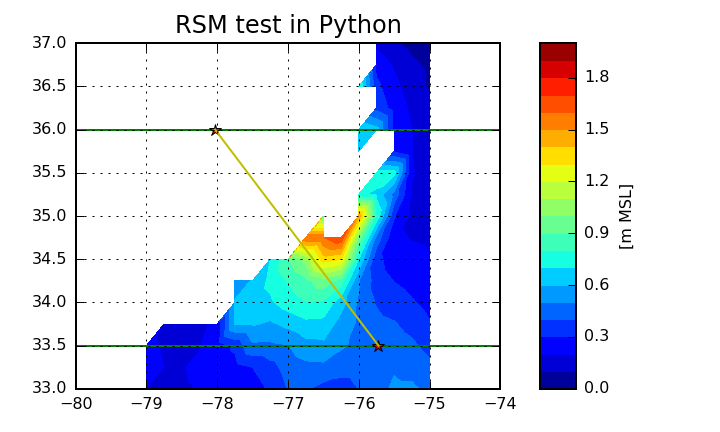

In [17]:
#rmw,H_b,TS,Vmax,LatNorth,LatSouth
interact(master, \
         rmw     =widgets.FloatSlider(min=p1min,max=p1max,step=dp1,value=rmw),\
         H_b     =widgets.FloatSlider(min=p2min,max=p2max,step=dp2,value=H_b),\
         TS      =widgets.FloatSlider(min=p3min,max=p3max,step=dp3,value=TS),\
         Vmax    =widgets.FloatSlider(min=p4min,max=p4max,step=dp4,value=Vmax),\
         LatNorth=widgets.FloatSlider(min=p5min,max=p5max,step=dp5,value=LatNorth),\
         LatSouth=widgets.FloatSlider(min=p6min,max=p6max,step=dp6,value=LatSouth))